## Using DVAE to detect anomalies in a dataset with delay-in-flap-deployment anomalies during approach to landing

### Authors: Thomas Templin (thomas.templin@nasa.gov), Milad Memarzadeh (milad.memarzadeh@nasa.gov)

In [1]:
# We need the following imports:
import discrete_stochastic_gaussian as dsg
import discrete_stochastic_bernoulli as dsb
import discrete_stochastic_rbm as dsr
from discrete_stochastic_training import *
from discrete_stochastic_utils import *
from discrete_stochastic_evaluation import *

In the following block, we set a few model hyperparameters. When using the model on a new dataset, the hyperparameters need to be re-tuned or adjusted.

In [2]:
# If hyperparameters affecting training are changed below, a new model needs to be trained
model_type = 'boltzmann'
num_epochs = 400
mode = 'testing'    # 'validation' for hyperparameter tuning and model selection, 'testing' for evaluation of the final version of the model
dir2data = './'
dataset = 'DASHlink_binary_Flaps_withAnomalies'
batch_size = 128
latent_dim = 32
metric = 'BCE'    # metric to be used for the reconstruction loss, i.e., binary cross entropy (BCE) or mean squared error (MSE)
kld_type = 'stochastic'    # whether to use the stochstic approximation or the anlaytic expression for calculating the KL divergence of the Bernoulli model'
regress = False    # whether to implement a conditional approximate posterior
beta = 30.0    # hyperparameter beta that controls the tradeoff between the reconstruction and KL-divergence terms of the beta-ELBO 
lamb = 0.1    # temperature of the concrete distribution
num_sample = 10    # number of samples to find anomaly-score threshold and test set-label predictions
perc_out = 4.5005    # percentage of outliers in training set
data_transformation = 'none'    # transformation applied to anomaly scores (to make them more similar to a normal distirbution)
v_rbm = 2    # RBM version
num_fantasy_particles = 500
len_persistent_chain = 25
w_l2 = 0.0    # weight of L2 penalty of RBM weight decay
nW = False    # whether to set elements of RBM weight matrix to zero ('Bernoulli mode')
sr_buffer = False    # whether to use a sampling replay buffer

# Create logger
logging.basicConfig(level=os.environ.get("LOGLEVEL", "INFO"), filename='discrete_stochastic.log')
logger = logging.getLogger("Discrete-Stochastic-Log")
logger.info("initializing...")

# Set to True if you want to train a new model
# Set to False if you want to load a pre-trained model
training_flag = False

### Dataset

The dataset contains 21 302 instances, 954 (4.48%) of which exhibit a delay-in-flap-deployment anomaly. Data instances cover 160 time points of the final approach to landing (one time point per second), and every time point includes the ten attributes corrected angle of attack, baromatric altitude, computed airspeed, trailing-edge flap position, glideslope deviation, average thrust of engines, pitch angle, roll angle, true heading, and wind speed. The dataset is divided into training (60%), validation (20%), and test (20%) sets.

__Note__: All data instances are labeled. Since the learning is unsupervised, labels are not used during training. They are only used for hyperparameter tuning (validation set) and during evaluation, to assess model perforamance (test set).

In [3]:
if dir2data == './':
    train_data = np.load(dataset+"_train.npz")
    valid_data = np.load(dataset+"_valid.npz")
    test_data = np.load(dataset+"_test.npz")
else:
    train_data = np.load(Path(dir2data+"/"+dataset+"_train.npz"))
    valid_data = np.load(Path(dir2data+"/"+dataset+"_valid.npz"))
    test_data = np.load(Path(dir2data+"/"+dataset+"_test.npz"))
x_train = train_data['data']
x_valid = valid_data['data']
x_test = test_data['data']
y_valid = valid_data['label']
y_test = test_data['label']
if mode == 'testing':
    x_train = np.concatenate((x_train, x_valid))
    x_eval = x_test
    y_eval = y_test
else:
    x_eval = x_valid
    y_eval = y_valid
    
len_x_train = len(x_train)

print('Axes: (instances, time points, attributes)')
print('Training set:', x_train.shape)
if mode != 'testing':
    print('Validation set:', x_valid.shape)
print('Evaluation set:', x_eval.shape)

Axes: (instances, time points, attributes)
Training set: (7980, 160, 10)
Evaluation set: (3990, 160, 10)


In [4]:
# This block ensures that the appropriate error metric is used (refer to source code for more information)
# Here, we use BCE because the data is normalized to lie between zero and one

min_value = np.min(x_train)
max_value = np.max(x_train)

print('min_value =', min_value)
print('max_value =', max_value)

# We round the minimum and maximum values used to test for standard scaling because the minimum and maximum
# values used for standard scaling are derived from the (original) training set and in testing mode the training
# and validation sets are combined for training. Since a few values of the validation set might slightly exceed
# the interval [0, 1], values of the new combined training set might exceed them as well.
# The likelihood_loss function (in discrete_stochastic_utils.py) takes care of any exceedances by clamping the
# input data and the reconstructed input data. 
if np.round(min_value, 1) < 0 or np.round(max_value, 1) > 1:
    if metric == 'BCE':
        logger.info("Due to standard scaling of the data, only the MSE can be used as error metric.")
    metric = 'MSE'

min_value = -0.020065408
max_value = 1.0


This block contains a few steps to prepare model training.

In [5]:
# Test for GPU availability
cuda = t.cuda.is_available()

# Determine length of time series and number of attributes
window_size = np.shape(x_train)[1]
num_param = np.shape(x_train)[2]

# Transposition of second and third dimensions because in PyTorch the feature dimension comes before the time dimension
x_train = np.transpose(x_train, axes=(0, 2, 1))
x_valid = np.transpose(x_valid, axes=(0, 2, 1))
x_eval = np.transpose(x_eval, axes=(0, 2, 1))
training = Dataset(x_train)
validation = Dataset(x_valid)

# Here, we just use one iteration of the model and set the iteration index i to 0.
i = 0

model_name = "discrete_stochastic_mtype_"+model_type+\
             "_epochs"+str(num_epochs)+\
             "_data_"+dataset+\
             "_bs"+str(batch_size)+\
             "_l"+str(latent_dim)+\
             "_b"+str(beta)+\
             "_pc"+str(len_persistent_chain)+\
             "_wd"+str(w_l2)+\
             "_iter"+str(i+1)

# Load the separate training and validation dataloader for PyTorch
train, valid = get_dataset(training, validation, batch_size=batch_size)

# Setting up the model, the optimizer, and the learning-rate scheduler
if model_type == 'continuous':
    model = dsg.VAE(latent_dim, num_param, window_size, regress, metric)
elif model_type == 'discrete':
    model = dsb.VAE(latent_dim, num_param, window_size, regress, metric, lamb, kld_type)
elif model_type == 'boltzmann':
    model = dsr.VAE(latent_dim, num_param, window_size, regress, metric, lamb, v_rbm, batch_size,
                num_fantasy_particles, len_persistent_chain, nW, len_x_train, num_epochs, sr_buffer, model_name)
if cuda: model = model.cuda()
    
optimizer = t.optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999))
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

RBM2 init


In [6]:
# Here, we train and save a new model (if training_flag == True)
if training_flag:
    model = train_model(model_type, model, optimizer, scheduler, logger, model_name, mode, train, valid,
                        metric, beta, num_epochs, len_x_train, batch_size, num_param, window_size)

### Training history

We saved the training losses over the epochs of training. Here, we visualize them, to make sure that the model trained properly.
The KL-divergence loss of a model with RBM prior is negative because the log probability of the RBM prior, log p(z), is not normalized.

__Note__: If you trained a new model, the file with the training-history data should have been saved in your directory.

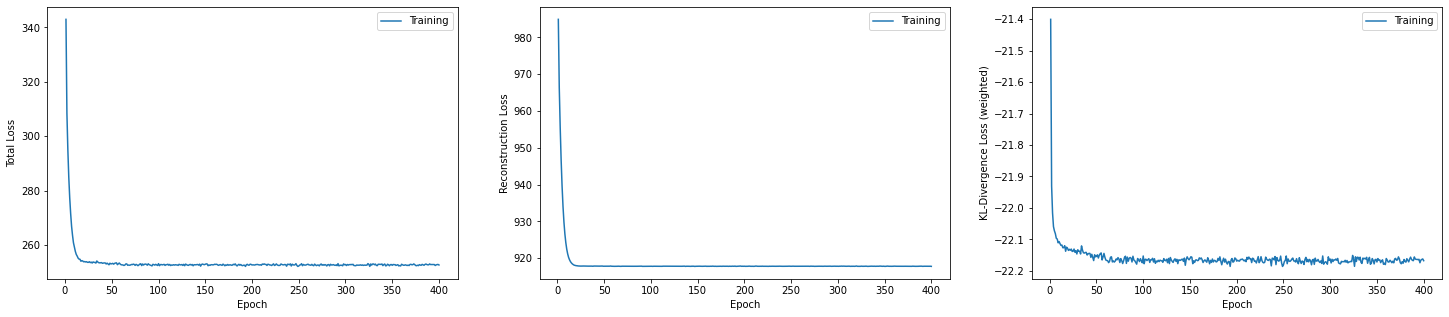

In [7]:
def plot_losses(num, training_loss, validation_loss, loss_type):
    plt.subplot(1, 3, num)
    plt.plot(range(1, len(training_loss)+1), training_loss, label='Training')
    if mode != 'testing':
        plt.plot(range(1, len(training_loss)+1), validation_loss, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel(loss_type)
    plt.xticks()
    plt.yticks()
    lgnd = plt.legend()


i = 0    # first iteration index

# Instantiate and pre-allocate loss arrays
training_lh_loss = np.zeros((i+1, num_epochs))
training_kld_loss = np.zeros((i+1, num_epochs))
training_loss = np.zeros((i+1, num_epochs))
validation_lh_loss = np.zeros((i+1, num_epochs))
validation_kld_loss = np.zeros((i+1, num_epochs))
validation_loss = np.zeros((i+1, num_epochs))

# Load losses
losses = np.load(model_name+".npz")

training_lh_loss[i, :] = losses['training_lh_loss']
training_kld_loss[i, :] = losses['training_kld_loss']
training_loss[i, :] = losses['training_loss']
validation_lh_loss[i, :] = losses['validation_lh_loss']
validation_kld_loss[i, :] = losses['validation_kld_loss']
validation_loss[i, :] = losses['validation_loss']

# Make subplots of losses over epochs
plt.figure(figsize=(25, 5))
plot_losses(1, training_loss[i, :], validation_loss[i, :], 'Total Loss')
plot_losses(2, training_lh_loss[i, :], validation_lh_loss[i, :], 'Reconstruction Loss')
plot_losses(3, training_kld_loss[i, :], validation_kld_loss[i, :], 'KL-Divergence Loss (weighted)')

### Latent units and energy

We also saved the values of the latent units and the energy over all minibatch iterations and display them here averaged over latent units and minibatch instances.

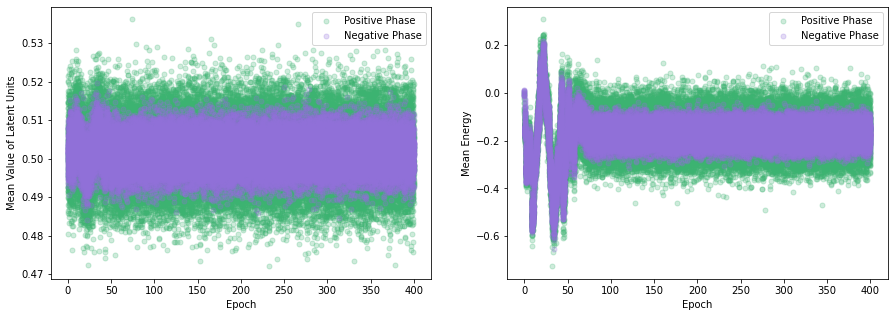

In [8]:
def plot_latent_space_properties (num, inds, positive_array, negative_array, proprty, x, labels):
    plt.subplot(1, 2, num)
    plt.scatter(inds, positive_array, s=25, color='mediumseagreen', alpha=0.25)
    plt.scatter(inds, negative_array, s=25, color='mediumpurple', alpha=0.25)
    plt.xlabel('Epoch')
    plt.ylabel(proprty)
    plt.xticks(x, labels)
    plt.yticks()
    lgnd = plt.legend(['Positive Phase', 'Negative Phase'])
    

# UNCOMMENT THIS LINE IF YOUR MODEL WAS TRAINED ON THE PRUNED DATASET PROVIDED ON GITHUB
len_x_train = 17087

# Instantiate and pre-allocate arrays for latent-space visualization
positive_array_flat = np.zeros((i+1, num_epochs*int(np.ceil(len_x_train/batch_size))))
negative_array_flat = np.zeros((i+1, num_epochs*int(np.ceil(len_x_train/batch_size))))
positive_energy_array_flat = np.zeros((i+1, num_epochs*int(np.ceil(len_x_train/batch_size))))
negative_energy_array_flat = np.zeros((i+1, num_epochs*int(np.ceil(len_x_train/batch_size))))

# Load arrays for latent-space visualization
full_data_positive = np.load("z_"+model_name+".npz")
positive_array = full_data_positive['latents']
positive_array_flat[i, :] = positive_array.flatten()
if model_type == 'boltzmann':
    full_data_negative = np.load("zt_"+model_name+".npz")
    negative_array = full_data_negative['fantasy_particles']
    positive_energy_array = full_data_negative['positive_phase_energy']
    negative_energy_array = full_data_negative['negative_phase_energy']
    negative_array_flat[i, :] = negative_array.flatten()
    positive_energy_array_flat[i,:] = positive_energy_array.flatten()
    negative_energy_array_flat[i,:] = negative_energy_array.flatten()
    
inds = np.arange(1, len(positive_array_flat[0, :])+1)

# Make figures for latent-space visualization
x = [(len(positive_array_flat[0, :])+1)*epoch/num_epochs for epoch in np.linspace(0, num_epochs, 9)]
labels = [int(epoch) if epoch%1==0 else epoch for epoch in np.linspace(0, num_epochs, 9)]
plt.figure(figsize=(15, 5))
plot_latent_space_properties(1, inds, positive_array_flat[i, :], negative_array_flat[i, :],
                             'Mean Value of Latent Units', x, labels)
plot_latent_space_properties(2, inds, positive_energy_array_flat[i, :], negative_energy_array_flat[i, :],
                             'Mean Energy', x, labels)

### Performance on test set

Here, we display numerical performance metrics and the separation of nominal and anomalous instances.

RBM2 init
j = 1
j = 2
j = 3
j = 4
j = 5
j = 6
j = 7
j = 8
j = 9
j = 10
jj = 1
jj = 2
jj = 3
jj = 4
jj = 5
jj = 6
jj = 7
jj = 8
jj = 9
jj = 10


'Precision = 62.63%, recall = 66.85%, F1 score = 64.67%'

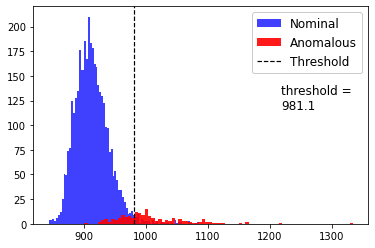

In [9]:
# Setting up the model (CPU version; for evaluation)
if model_type == 'continuous':
    model = dsg.VAE(latent_dim, num_param, window_size, regress, metric)
elif model_type == 'discrete':
    model = dsb.VAE(latent_dim, num_param, window_size, regress, metric, lamb, kld_type)
elif model_type == 'boltzmann':
    model = dsr.VAE(latent_dim, num_param, window_size, regress, metric, lamb, v_rbm, batch_size,
                 num_fantasy_particles, len_persistent_chain, nW, len_x_train, num_epochs, sr_buffer, model_name, cuda=False)

# Load saved model and map it to CPU
model.load_state_dict(t.load((model_name+".pth"), map_location=t.device('cpu')), strict=False)

# Evaluation (no weight updates)
model.eval()

# Finding anomaly scores and the threshold for anomaly detection
scale = norm.ppf(1 - perc_out/100)      # quantile function (inverse CDF): returns z-score of standard normal distribution
anomaly_score_train = find_score(x_train, num_sample, model_type, model, 'training', data_transformation, metric)
if data_transformation == 'inv':
    threshold = np.mean(anomaly_score_train) - scale*np.std(anomaly_score_train, ddof=1)   # thr = E[anomaly_score] - scale*std(anomaly_score)
else:
    threshold = np.mean(anomaly_score_train) + scale*np.std(anomaly_score_train, ddof=1)   # thr = E[anomaly_score] + scale*std(anomaly_score)

# Test the model
anomaly_score_eval = find_score(x_eval, num_sample, model_type, model, 'evaluation', data_transformation, metric)
pred_eval = np.zeros(len(y_eval))
n = anomaly_score_eval[y_eval==0.]    # nominal
p = anomaly_score_eval[y_eval==1.]    # anomalous

# Make plot of anomaly scores
if data_transformation == 'inv':
    # If the inverse transformation is used on the anomaly scores,
    # the historgram is reversed (reflected about the highest anomaly score),
    # so that anomalies appear on the right 
    max_ase = np.max(anomaly_score_eval)
    n = max_ase - n
    p = max_ase - p
    threshold_refl = max_ase - threshold
else:
    threshold_refl = threshold
threshold4g = format(threshold_refl, '#.4g')           # threshold with 4 significant digits including trailing zeros
ax = plt.gca()
plt.hist(n, bins=80, alpha=0.75, color='blue', label='Nominal')
plt.hist(p, bins=80, alpha=0.9, color='red', label='Anomalous')
plt.axvline(x=threshold_refl, ymax = 1, c='k', lw='1.2', ls='dashed', alpha=1, label='Threshold')
plt.legend(fontsize=12, loc='upper right', framealpha=1)
plt.text(0.74, 0.64, 'threshold =\n'+str(threshold4g), fontsize=12, ha='left', va='top', transform=ax.transAxes)

if data_transformation == 'inv':
    pred_eval[anomaly_score_eval <= threshold] =  1   # Logical vector (component = 1 if anomaly score is less than thr, 0 otherwise)
    max_ase = np.max(anomaly_score_eval)
    anomaly_score_eval = max_ase - anomaly_score_eval
else:
    pred_eval[anomaly_score_eval >= threshold] =  1   # Logical vector (component = 1 if anomaly score exceeds thr, 0 otherwise)
    
# Determine performance metrics
acc, pr, rc, f1  = determine_metrics(y_eval, pred_eval)

"Precision = {}%, recall = {}%, F1 score = {}%".format(np.round(pr*100, 2),
                                                       np.round(rc*100, 2),
                                                       np.round(f1*100, 2))

### Confusion matrix

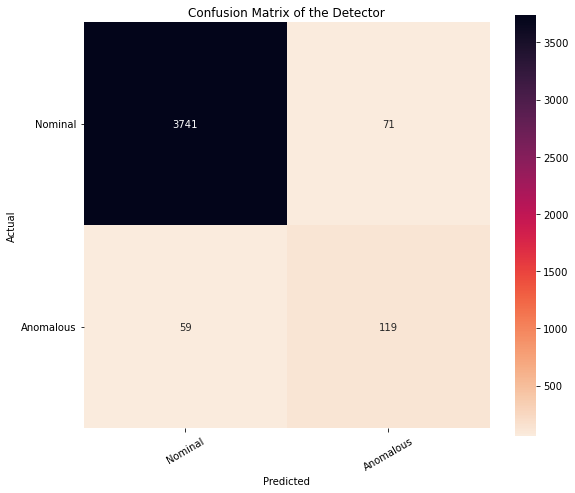

In [10]:
plt.figure(figsize=(9, 7.5))
conf_mat = confusion_matrix(y_eval, pred_eval)
conf_mat = np.round(conf_mat)
heatmap(conf_mat, square=True, annot=True, cbar=True, xticklabels=['Nominal', 'Anomalous'],
        yticklabels=['Nominal', 'Anomalous'], cmap=cm.rocket_r, fmt='g')
plt.tight_layout()
plt.xticks(rotation=30)
plt.yticks(rotation=0)
plt.title('Confusion Matrix of the Detector')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.gcf().subplots_adjust(left=0.2)
plt.gcf().subplots_adjust(bottom=0.2)